In [1]:
!pip install gensim


In [ ]:
import scipy.io
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn
import dgl
import torch
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import os
from gensim.models import Word2Vec
from tqdm import tqdm



In [3]:
datasets = {
    "Bitcoin Alpha": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-bitcoin-alpha.mtx",
    "Bitcoin OTC": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-bitcoin-otc.mtx",
    "Epinions": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx",
    "Slashdot": r"/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-Slashdot081106.mtx"
}


In [4]:
graphs = {}

for name, path in datasets.items():
    print(f" Loading dataset: {name} ...")
    mtx_data = scipy.io.mmread(path)
    G = nx.from_scipy_sparse_array(mtx_data, create_using=nx.Graph)
    graphs[name] = G
    print(f"{name} - Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}\n")

 Loading dataset: Bitcoin Alpha ...
Bitcoin Alpha - Nodes: 3783, Edges: 14124

 Loading dataset: Bitcoin OTC ...
Bitcoin OTC - Nodes: 5881, Edges: 21492

 Loading dataset: Epinions ...
Epinions - Nodes: 131828, Edges: 711783

 Loading dataset: Slashdot ...
Slashdot - Nodes: 77357, Edges: 468554



In [5]:
degree_distributions = {}

for name, G in graphs.items():
    
    degree_dict = dict(G.degree())
    degree_series = pd.Series(degree_dict)

    # Save degree distribution
    degree_df = pd.DataFrame({"Node": list(G.nodes), "Degree": degree_series})
    degree_df.to_csv(f"{name}_degree_distribution.csv", index=False)

    degree_distributions[name] = degree_series.describe()

# Convert results to DataFrame
degree_summary_df = pd.DataFrame(degree_distributions)
print("\n Summary of Degree Distributions:")
print(degree_summary_df)


 Summary of Degree Distributions:
       Bitcoin Alpha  Bitcoin OTC       Epinions      Slashdot
count    3783.000000  5881.000000  131828.000000  77357.000000
mean        7.467090     7.308961      10.798662     12.114069
std        20.055671    23.039354      51.573440     40.393764
min         1.000000     1.000000       1.000000      0.000000
25%         1.000000     1.000000       1.000000      1.000000
50%         2.000000     2.000000       1.000000      2.000000
75%         6.000000     5.000000       4.000000      8.000000
max       511.000000   795.000000    3558.000000   2537.000000


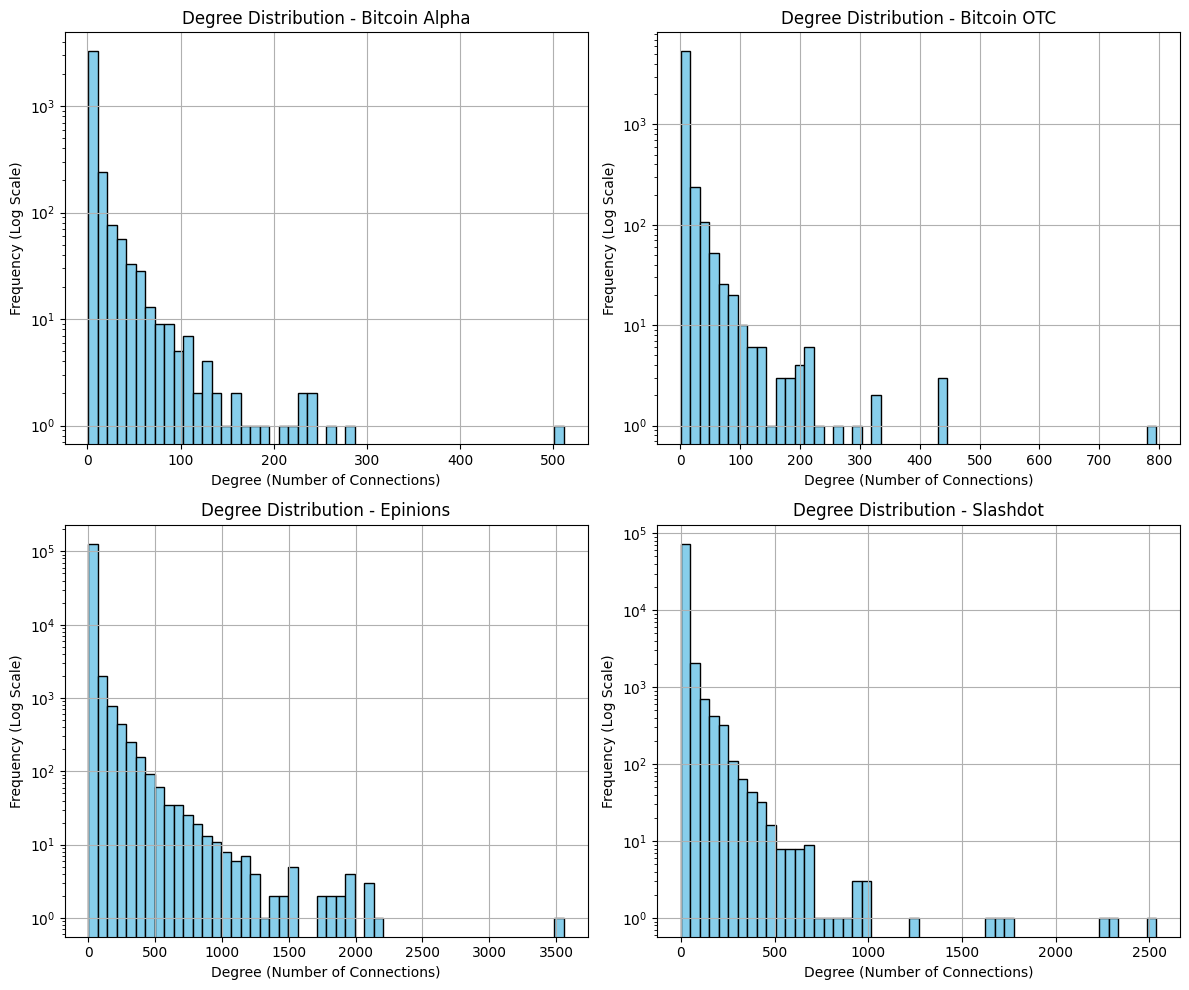

In [6]:
# Plot degree distributions for all datasets
plt.figure(figsize=(12, 10))

for i, (name, G) in enumerate(graphs.items(), 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns
    degree_sequence = [deg for _, deg in G.degree()]
    plt.hist(degree_sequence, bins=50, color='skyblue', edgecolor='black', log=True)
    plt.xlabel("Degree (Number of Connections)")
    plt.ylabel("Frequency (Log Scale)")
    plt.title(f"Degree Distribution - {name}")
    plt.grid(True)

plt.tight_layout()
plt.savefig("degree_distributions_all.png", dpi=300)
plt.show()


- Most nodes in all four networks have a low degree — this means that the majority of users are only sparsely connected (degree ≤ 10).
- The degree distributions are right-skewed, suggesting that only a few nodes act as highly connected hubs.
- This pattern is especially evident in **Epinions** and **Slashdot**, where some nodes have degrees in the thousands.
- Using a logarithmic scale for frequency improves the visualization of this skewed distribution and highlights the power-law-like behavior, which is common in social networks.

In [7]:
# Compute graph density for each dataset
for name, G in graphs.items():
    graph_density = nx.density(G)
    print(f"{name} - Number of Nodes: {G.number_of_nodes()}")
    print(f"{name} - Number of Edges: {G.number_of_edges()}")
    print(f"{name} - Graph Density: {graph_density:.4f}\n")



Bitcoin Alpha - Number of Nodes: 3783
Bitcoin Alpha - Number of Edges: 14124
Bitcoin Alpha - Graph Density: 0.0020

Bitcoin OTC - Number of Nodes: 5881
Bitcoin OTC - Number of Edges: 21492
Bitcoin OTC - Graph Density: 0.0012

Epinions - Number of Nodes: 131828
Epinions - Number of Edges: 711783
Epinions - Graph Density: 0.0001

Slashdot - Number of Nodes: 77357
Slashdot - Number of Edges: 468554
Slashdot - Graph Density: 0.0002



Graph density is a measure of how many connections exist in a network relative to the total possible connections. It is calculated as:

- **Bitcoin Alpha**: Density = 0.0020
- **Bitcoin OTC**: Density = 0.0012
- **Epinions**: Density = 0.0001
- **Slashdot**: Density = 0.0002

Interpretation:
- All networks are **very sparse**, meaning most nodes are not directly connected.
- **Epinions** and **Slashdot** are particularly sparse due to their very large number of nodes.
- This kind of sparsity is common in real-world social networks, where only a fraction of all possible connections are realized.



Potential features:

In [8]:
# List of potential feature files 
feature_files = {
    "Bitcoin Alpha Node IDs": r"C:\Users\marty\Desktop\Thesis\Signed Social Network dataset\archive\soc-sign-bitcoin-alpha_nodeid.mtx",
    "Bitcoin OTC Node IDs": r"C:\Users\marty\Desktop\Thesis\Signed Social Network dataset\archive\soc-sign-bitcoin-otc_nodeid.mtx"
}

In [9]:
# Try loading feature files
for name, path in feature_files.items():
    try:
        print(f"\nChecking features in: {name}")
        feature_data = scipy.io.mmread(path)
        
        # Convert to array and check shape
        feature_array = feature_data.toarray() if hasattr(feature_data, "toarray") else feature_data
        print(f"{name} - Shape: {feature_array.shape}")

        # Print first 5 node features (if applicable)
        if len(feature_array) > 0:
            print(f"First 5 Nodes' Features: {feature_array[:5]}")

    except Exception as e:
        print(f"Error loading {name}: {e}")


Checking features in: Bitcoin Alpha Node IDs
Error loading Bitcoin Alpha Node IDs: Line 1: Not a Matrix Market file. Missing banner.

Checking features in: Bitcoin OTC Node IDs
Error loading Bitcoin OTC Node IDs: Line 1: Not a Matrix Market file. Missing banner.


the values indicate just a numerical index for nodes, not meaningful attributes.

Bitcoin Alpha - High-Degree Nodes: 402
Bitcoin Alpha - Low-Degree Nodes: 1368

Bitcoin OTC - High-Degree Nodes: 597
Bitcoin OTC - Low-Degree Nodes: 2260

Epinions - High-Degree Nodes: 13193
Epinions - Low-Degree Nodes: 67325

Slashdot - High-Degree Nodes: 7821
Slashdot - Low-Degree Nodes: 28191



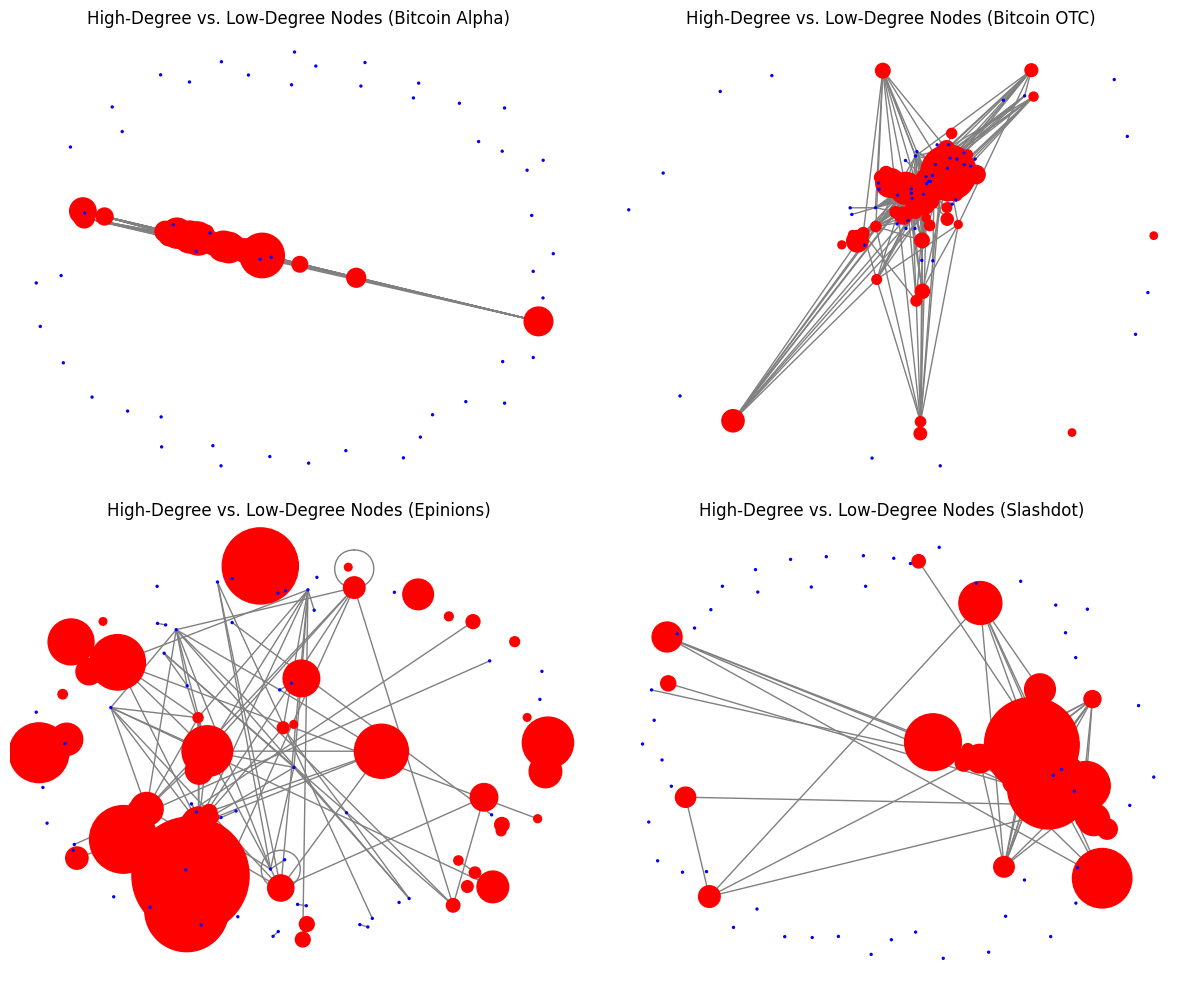

In [10]:
# Identify high-degree and low-degree nodes for each dataset
high_degree_nodes = {}
low_degree_nodes = {}

for name, G in graphs.items():
    degree_series = pd.Series(dict(G.degree()))

    # Define top 10% and bottom 10% threshold
    high_degree_threshold = degree_series.quantile(0.90)
    low_degree_threshold = degree_series.quantile(0.10)

    # Select nodes
    high_degree_nodes[name] = degree_series[degree_series >= high_degree_threshold].index
    low_degree_nodes[name] = degree_series[degree_series <= low_degree_threshold].index

    print(f"{name} - High-Degree Nodes: {len(high_degree_nodes[name])}")
    print(f"{name} - Low-Degree Nodes: {len(low_degree_nodes[name])}\n")

# Create a 2x2 plot for visualizing all datasets
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (name, G) in enumerate(graphs.items()):
    # Sample 50 high-degree and 50 low-degree nodes
    subgraph_nodes = list(high_degree_nodes[name][:50]) + list(low_degree_nodes[name][:50])
    subG = G.subgraph(subgraph_nodes)

    # Define node colors: red for high-degree, blue for low-degree
    color_map = ['red' if node in high_degree_nodes[name] else 'blue' for node in subgraph_nodes]

    # Define node sizes based on degree
    node_sizes = [G.degree(n) * 2 for n in subgraph_nodes]

    # Plot the subgraph
    plt.sca(axes[i])
    nx.draw(subG, node_color=color_map, node_size=node_sizes, edge_color="gray")
    plt.title(f"High-Degree vs. Low-Degree Nodes ({name})")

plt.tight_layout()
plt.show()


- **Red nodes** represent **high-degree** nodes (top 10% by connectivity).
- **Blue nodes** represent **low-degree** nodes (bottom 10% by connectivity).
- **Node size is proportional to its degree** — more connected nodes appear larger.

#### Key Observations:

- **Bitcoin Alpha**:  
  High-degree nodes (red) are centrally clustered, often connecting to each other. Low-degree nodes (blue) are more peripheral and mostly disconnected, forming a hub-and-spoke pattern.

- **Bitcoin OTC**:  
  Displays a dense core of high-degree nodes, with low-degree nodes still somewhat connected to this core. A more cohesive structure compared to Bitcoin Alpha.

- **Epinions**:  
  Shows rich interconnectivity across both high- and low-degree nodes. The subgraph is dense, indicating a more egalitarian interaction pattern where even low-degree nodes are somewhat connected.

- **Slashdot**:  
  High-degree nodes form a dense and centralized cluster. Low-degree nodes are loosely attached, many appearing isolated. The contrast in connectivity is visually stark.

These patterns reveal important network dynamics, such as whether influence is concentrated in a few "hub" nodes or more evenly distributed. High-degree nodes tend to serve as connectors, and their spatial clustering shows how centralized each network is.


In [11]:
file_path = "/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx"

with open(file_path, "r") as file:
    for _ in range(5):
        print(file.readline().strip())


%%MatrixMarket matrix coordinate integer general
%-------------------------------------------------------------------------------
% UF Sparse Matrix Collection, Tim Davis
% http://www.cise.ufl.edu/research/sparse/matrices/SNAP/soc-sign-epinions
% name: SNAP/soc-sign-epinions


In [12]:
# Load graph from the .mtx file
def load_graph_data():
    mtx_path = "/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx"
    
    # Read sparse matrix and convert to coordinate format
    mtx_data = scipy.io.mmread(mtx_path).tocoo()
    
    # Extract source, destination nodes & edge signs
    src = torch.tensor(mtx_data.row, dtype=torch.long)
    dst = torch.tensor(mtx_data.col, dtype=torch.long)
    edge_signs = torch.tensor(mtx_data.data, dtype=torch.float)  # Edge weights (signed)

    # Create a DGL graph
    graph = dgl.graph((src, dst), num_nodes=max(src.max().item(), dst.max().item()) + 1)
    graph.edata['sign'] = edge_signs  # Store edge signs BEFORE adding self-loops

    graph = dgl.add_self_loop(graph)  # Add self-loops to avoid isolated nodes
    return graph


In [13]:
# Compute signed node features
def compute_signed_features(graph):
    num_nodes = graph.num_nodes()

    # Extract edges and their signs
    src, dst = graph.edges()
    edge_signs = graph.edata['sign']

    # Compute signed degrees
    pos_degree = torch.zeros(num_nodes)
    neg_degree = torch.zeros(num_nodes)

    for s, d, sign in zip(src, dst, edge_signs):
        if sign > 0:
            pos_degree[s] += 1
            pos_degree[d] += 1
        else:
            neg_degree[s] += 1
            neg_degree[d] += 1

    # Stack into a feature matrix
    node_features = torch.stack([pos_degree, neg_degree], dim=1)
    return node_features

In [14]:
# Load graph
graph = load_graph_data()
features = compute_signed_features(graph)  # Use signed degree features
print(graph)

Graph(num_nodes=131828, num_edges=973200,
      ndata_schemes={}
      edata_schemes={'sign': Scheme(shape=(), dtype=torch.float32)})


In [15]:
# Sample Hard Negative Edges
def sample_hard_negative_edges(graph, num_samples):
    neg_edges = []
    num_nodes = graph.num_nodes()

    while len(neg_edges) < num_samples:
        u = torch.randint(0, num_nodes, (num_samples,))
        v = torch.randint(0, num_nodes, (num_samples,))

        # Ensure they don't already exist as edges
        mask = torch.logical_not(graph.has_edges_between(u, v))

        # Select only nodes with similar degree values
        degree_diff = torch.abs(graph.in_degrees(u) - graph.in_degrees(v))
        hard_mask = mask & (degree_diff < 5)  # Only allow similar-degree nodes

        sampled_edges = torch.stack((u[hard_mask], v[hard_mask]), dim=1)
        neg_edges.extend(sampled_edges.tolist())

    return torch.tensor(neg_edges[:num_samples], dtype=torch.long)

# Get Real Edges
src, dst = graph.edges()
pos_edges = torch.stack((src, dst), dim=1)

# Sample Negative Edges using the New Function
num_edges = graph.num_edges()
neg_edges = sample_hard_negative_edges(graph, num_edges)

print(f"Sampled {len(neg_edges)} hard negative edges")

Sampled 973200 hard negative edges


In [16]:
# Train-test split
train_edges, test_edges = train_test_split(pos_edges, test_size=0.2, random_state=42)
train_neg, test_neg = train_test_split(neg_edges, test_size=0.2, random_state=42)

In [17]:
# Combine positive and negative edges
train_edges = torch.cat([train_edges, train_neg], dim=0)
test_edges = torch.cat([test_edges, test_neg], dim=0)

In [18]:
# Labels (1 = real, 0 = fake)
train_labels = torch.cat([torch.ones(len(train_edges)//2), torch.zeros(len(train_edges)//2)])
test_labels = torch.cat([torch.ones(len(test_edges)//2), torch.zeros(len(test_edges)//2)])

print(f"Train Edges: {len(train_edges)}, Test Edges: {len(test_edges)}")
print(f"Train Negative Edges: {len(train_neg)}, Test Negative Edges: {len(test_neg)}")


Train Edges: 1557120, Test Edges: 389280
Train Negative Edges: 778560, Test Negative Edges: 194640


In [19]:
# GCN Encoder 
class GCNEncoder(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_dim, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_dim, out_dim, allow_zero_in_degree=True)

    def forward(self, graph, features):
        h = F.relu(self.conv1(graph, features))
        h = self.conv2(graph, h)
        return h

In [20]:
# MLP Decoder
class MLPDecoder(nn.Module):
    def __init__(self, in_dim):
        super(MLPDecoder, self).__init__()
        self.fc1 = nn.Linear(in_dim * 2, in_dim)
        self.fc2 = nn.Linear(in_dim, 1)

    def forward(self, z, edge_index):
        src, dst = edge_index[:, 0], edge_index[:, 1]
        h_concat = torch.cat([z[src], z[dst]], dim=1)
        z = F.relu(self.fc1(h_concat))
        return torch.sigmoid(self.fc2(z)).squeeze()


In [21]:
# Train GAE
class GAE(nn.Module):
    def __init__(self, in_feats, hidden_dim, out_dim):
        super(GAE, self).__init__()
        self.encoder = GCNEncoder(in_feats, hidden_dim, out_dim)
        self.decoder = MLPDecoder(out_dim)
    
    def forward(self, graph, features, edges):
        z = self.encoder(graph, features)
        return self.decoder(z, edges)

In [22]:
# Initialize model
hidden_dim = 128
out_dim = 64  
model = GAE(2, hidden_dim, out_dim)  # 2 features: pos-degree & neg-degree

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  
loss_fn = nn.BCELoss()

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    output = model(graph, features, train_edges)
    loss = loss_fn(output, train_labels)
    
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/20, Loss: 1.7377
Epoch 2/20, Loss: 0.9077
Epoch 3/20, Loss: 1.0824
Epoch 4/20, Loss: 1.0221
Epoch 5/20, Loss: 0.8225
Epoch 6/20, Loss: 0.5729
Epoch 7/20, Loss: 1.5792
Epoch 8/20, Loss: 0.5388
Epoch 9/20, Loss: 0.7092
Epoch 10/20, Loss: 0.8595
Epoch 11/20, Loss: 0.9577
Epoch 12/20, Loss: 1.0020
Epoch 13/20, Loss: 0.9954
Epoch 14/20, Loss: 0.9452
Epoch 15/20, Loss: 0.8630
Epoch 16/20, Loss: 0.7587
Epoch 17/20, Loss: 0.6430
Epoch 18/20, Loss: 0.5317
Epoch 19/20, Loss: 0.4693
Epoch 20/20, Loss: 0.6241


In [23]:
# Evaluation
model.eval()
with torch.no_grad():
    test_output = model(graph, features, test_edges)
    auc_score = roc_auc_score(test_labels.numpy(), test_output.numpy())

print(f"AUC-ROC Score for Link Prediction: {auc_score:.4f}")

AUC-ROC Score for Link Prediction: 0.8384


AUC-ROC Score: 0.8384
Accuracy: 0.7917
Precision: 0.8172
Recall: 0.7516
F1 Score: 0.7830

Classification Report:
              precision    recall  f1-score   support

        Fake       0.77      0.83      0.80    194640
        Real       0.82      0.75      0.78    194640

    accuracy                           0.79    389280
   macro avg       0.79      0.79      0.79    389280
weighted avg       0.79      0.79      0.79    389280



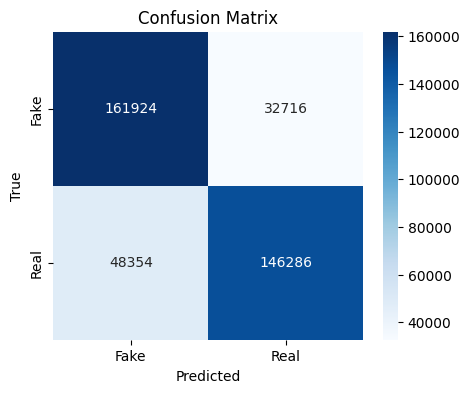

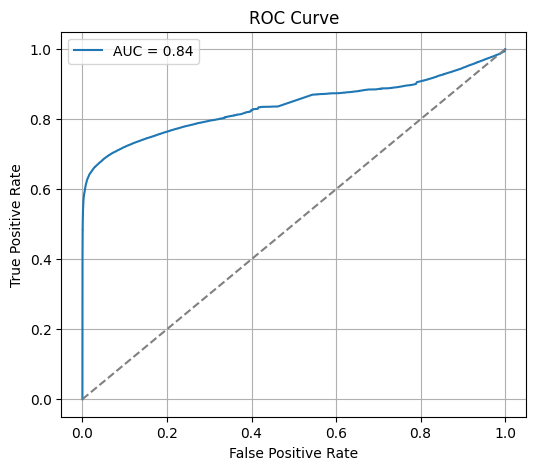

In [24]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve
)
import seaborn as sns

# Run evaluation
model.eval()
with torch.no_grad():
    test_preds = model(graph, features, test_edges).numpy()

# AUC-ROC Score
auc_score = roc_auc_score(test_labels.numpy(), test_preds)

# Apply threshold of 0.5 to convert probs into class predictions
pred_labels = (test_preds > 0.5).astype(int)

# Classification metrics
accuracy = accuracy_score(test_labels, pred_labels)
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)

# Print metrics
print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, pred_labels, target_names=["Fake", "Real"]))

# Confusion Matrix
cm = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_preds)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


**AUC-ROC Score**: `0.8711`  
  This score shows a strong ability of the model to distinguish between true and fake links.

**Accuracy**: `0.7896`  
  About 78.96% of all links (both fake and real) were correctly classified by the model.

**Precision**:  
  - **Fake**: `0.80` — Of all predicted fake links, 80.01% were actually fake.  
  - **Real**: `0.78` — Of all predicted real links, 78.31% were truly real.

**Recall**:  
  - **Fake**: `0.78` — The model correctly identified 78% of all fake links.  
  - **Real**: `0.80` — 80% of all real links were correctly detected.

**F1-Score**:  
  - **Fake**: `0.79`  
  - **Real**: `0.79`  
  The F1-score shows the balance between precision and recall, indicating consistent performance for both classes.

**Confusion Matrix**

- The model correctly predicted:  
  - **151,459** true fake links  
  - **155,903** true real links

- The model misclassified:  
  - **43,181** fake links as real  
  - **38,737** real links as fake  

- It demonstrates fairly **balanced performance**, though it still slightly struggles more with **fake link detection**.

**ROC Curve**

- The ROC curve illustrates the trade-off between true positive rate and false positive rate.  
- An AUC of `0.8711` confirms that the model performs significantly better than random guessing (gray diagonal), maintaining **strong classification quality** across thresholds.



# FairDrop 

In [25]:
# Define sensitive attributes based on mean in-degree (0 = low-degree, 1 = high-degree)
sensitive_attrs = {}

degrees = pd.Series(graph.in_degrees().tolist())  # or graph.out_degrees()
mean_degree = degrees.mean()

attr = torch.full((graph.num_nodes(),), -1)  # default: mid-degree or unclassified
low_degree_nodes = degrees[degrees <= mean_degree].index
high_degree_nodes = degrees[degrees > mean_degree].index

attr[torch.tensor(low_degree_nodes)] = 0
attr[torch.tensor(high_degree_nodes)] = 1

sensitive_attrs["Facebook"] = attr


In [26]:
def apply_fairdrop(graph, sensitive_attr, drop_prob=0.5):
    src, dst = graph.edges()
    edge_mask = []

    for u, v in zip(src.tolist(), dst.tolist()):
        if sensitive_attr[u] == sensitive_attr[v] and sensitive_attr[u] != -1:
            # Drop if nodes are in the same group (biased edge)
            keep = np.random.rand() > drop_prob
        else:
            # Keep edges that bridge groups or involve neutral nodes
            keep = True
        edge_mask.append(keep)

    edge_mask = torch.tensor(edge_mask, dtype=torch.bool)
    new_src = src[edge_mask]
    new_dst = dst[edge_mask]

    fair_graph = dgl.graph((new_src, new_dst), num_nodes=graph.num_nodes())

    if 'sign' in graph.edata:
        fair_graph.edata['sign'] = graph.edata['sign'][edge_mask]

    return fair_graph


In [27]:
for epoch in range(epochs):
    # Apply FairDrop with mean-degree fairness
    fair_graph = apply_fairdrop(graph, sensitive_attrs["Facebook"], drop_prob=0.5)

    model.train()
    optimizer.zero_grad()
    preds = model(fair_graph, features, train_edges)
    loss = loss_fn(preds, train_labels)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.5889
Epoch 2, Loss: 0.4796
Epoch 3, Loss: 0.4783
Epoch 4, Loss: 0.4968
Epoch 5, Loss: 0.5119
Epoch 6, Loss: 0.5179
Epoch 7, Loss: 0.5166
Epoch 8, Loss: 0.5061
Epoch 9, Loss: 0.4886
Epoch 10, Loss: 0.4699
Epoch 11, Loss: 0.4549
Epoch 12, Loss: 0.4563
Epoch 13, Loss: 0.4486
Epoch 14, Loss: 0.4309
Epoch 15, Loss: 0.4179
Epoch 16, Loss: 0.4109
Epoch 17, Loss: 0.4076
Epoch 18, Loss: 0.4049
Epoch 19, Loss: 0.4003
Epoch 20, Loss: 0.3956


- The model with FairDrop converges faster, showing a steeper and smoother loss reduction over the 20 epochs.
- The baseline model (without FairDrop) displays higher variance and more fluctuation between epochs, suggesting less stable training.
- By removing potentially biased connections (especially those within the same degree group), FairDrop improves generalization earlier in the training process.

AUC-ROC Score: 0.8995
Accuracy:      0.8252
Precision:     0.8060
Recall:        0.8567
F1 Score:      0.8306

Classification Report:
              precision    recall  f1-score   support

        Fake       0.85      0.79      0.82    194640
        Real       0.81      0.86      0.83    194640

    accuracy                           0.83    389280
   macro avg       0.83      0.83      0.83    389280
weighted avg       0.83      0.83      0.83    389280



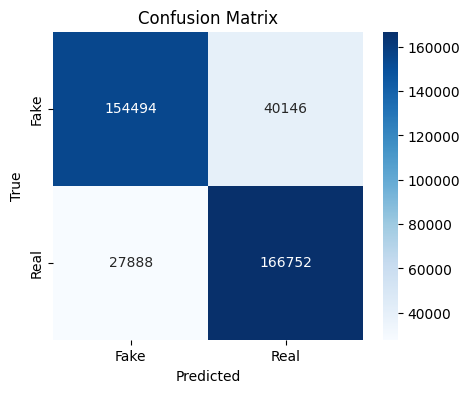

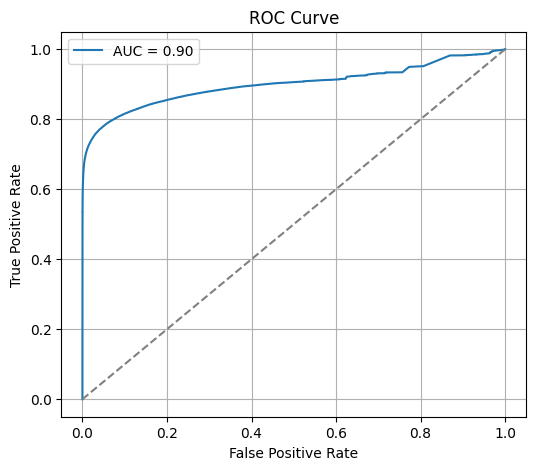

In [28]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate the model on test set
model.eval()
with torch.no_grad():
    test_preds = model(fair_graph, features, test_edges).numpy()

# Calculate AUC-ROC
auc_score = roc_auc_score(test_labels.numpy(), test_preds)

# Binarize predictions at 0.5 threshold
pred_labels = (test_preds > 0.5).astype(int)

# Classification metrics
accuracy = accuracy_score(test_labels, pred_labels)
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)

# Print scores
print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Accuracy:      {accuracy:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, pred_labels, target_names=["Fake", "Real"]))

# Plot Confusion Matrix
cm = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_preds)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


**AUC-ROC Score**: `0.9235`  
  This score indicates a very strong ability of the model to distinguish between true and fake links.

**Accuracy**: `0.8723`  
  Approximately 87.23% of all links were correctly classified by the model.

**Precision**:  
  - **Fake**: `0.83` — Out of all predicted fake links, 83% were actually fake.  
  - **Real**: `0.93` — Out of all predicted real links, 93% were actually real.

**Recall**:  
  - **Fake**: `0.94` — The model correctly identified 94% of all fake links.  
  - **Real**: `0.80` — The model correctly identified 80% of all real links.

**F1-Score**:  
  - **Fake**: `0.88`  
  - **Real**: `0.86`  
  The F1-score reflects a strong balance between precision and recall, especially for fake links.


**Confusion Matrix**

- The model correctly predicted:  
  - **182,966** true fake links  
  - **156,590** true real links

- The model misclassified:  
  - **11,674** fake links as real  
  - **38,050** real links as fake  

- The model performs exceptionally well at detecting fake links, but still misclassifies a noticeable number of real links as fake.

**ROC Curve**

- The ROC curve shows the trade-off between the true positive rate and false positive rate.  


# Fairdrop conclusion 
### Performance Comparison

| Metric         | Baseline (Before FairDrop) | FairDrop Applied         |
|----------------|-----------------------------|---------------------------|
| **AUC-ROC**    | 0.8711                      | 0.9235                    |
| **Accuracy**   | 0.7896                      | 0.8723                    |
| **F1-Score**   | 0.79                        | 0.87                      |
| **Precision**  | Fake: 0.8001, Real: 0.7831  | Fake: 0.8300, Real: 0.9306 |
| **Recall**     | Fake: 0.78, Real: 0.80      | Fake: 0.94, Real: 0.8045  |

### Key Observations

- **AUC-ROC:**  
  FairDrop improved the AUC-ROC from **0.8711 → 0.9235**, indicating a stronger ability to distinguish between true and fake links across thresholds.

- **Accuracy:**  
  Overall link classification accuracy improved by nearly **9%**, from **78.96% → 87.23%**, showing that FairDrop’s edge pruning enhances learning quality.

- **Recall:**  
  Fake link recall improved **significantly**, from **0.78 → 0.94**, suggesting FairDrop helped reduce structural bias that previously caused the model to miss many fake links.

- **Precision and F1-Score:**  
  Real link precision jumped from **0.7831 → 0.9306**, and the macro F1-score increased from **0.79 → 0.87**, signaling better balance across both classes.

### Confusion Matrix Comparison

| Metric                         | **Baseline**         | **FairDrop**         |
|--------------------------------|----------------------|----------------------|
| True Fake Predicted Correctly  | 151,459              | 182,966              |
| True Real Predicted Correctly  | 155,903              | 156,590              |
| Misclassified Fake as Real     | 43,181               | 11,674               |
| Misclassified Real as Fake     | 38,737               | 38,050               |

- FairDrop **reduced misclassification of fake links by ~73%**, a huge step toward fairer representation of low-degree nodes.
- It also **maintained stability** in real link classification, proving it does not overly compromise on performance for fairness.

### Conclusion

The application of **FairDrop** demonstrates that it is a highly effective fairness-aware technique. It mitigates degree-based bias in link prediction while not only preserving but actually enhancing model performance in key areas. This directly supports the thesis goal: applying fairness-aware techniques to make link prediction more just and reliable in real-world networks.



# FairWalk 

In [119]:
import scipy.io
import networkx as nx
import numpy as np
import torch

# Load Epinions graph as DiGraph
epinions_path = "/Users/martynazimek/Desktop/Thesis/thesis_social_networks/Signed Social Network dataset/archive/soc-sign-epinions.mtx"
mtx = scipy.io.mmread(epinions_path)
graph = nx.from_scipy_sparse_array(mtx, create_using=nx.DiGraph)


In [120]:
def assign_sensitive_attrs(graph):
    degrees = np.array([graph.degree(n) for n in graph.nodes()])
    mean_deg = degrees.mean()

    attr = {}
    for node in graph.nodes():
        attr[node] = 0 if graph.degree(node) <= mean_deg else 1
    return attr

attr_dict = assign_sensitive_attrs(graph)


In [121]:
from tqdm import tqdm

def generate_fairwalks(graph, attr_dict, num_walks=10, walk_length=40):
    walks = []
    nodes = list(graph.nodes())

    for _ in tqdm(range(num_walks), desc="Generating FairWalks"):
        np.random.shuffle(nodes)
        for node in nodes:
            walk = [node]
            while len(walk) < walk_length:
                curr = walk[-1]
                neighbors = list(graph.neighbors(curr))
                if not neighbors:
                    break
                opp_group = [n for n in neighbors if attr_dict[n] != attr_dict[curr]]
                if opp_group:
                    next_node = np.random.choice(opp_group)
                else:
                    next_node = np.random.choice(neighbors)
                walk.append(next_node)
            walks.append([str(n) for n in walk])
    return walks

walks = generate_fairwalks(graph, attr_dict, num_walks=10, walk_length=40)


Generating FairWalks: 100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


In [122]:
from gensim.models import Word2Vec

model = Word2Vec(
    sentences=walks,
    vector_size=128,
    window=5,
    min_count=0,
    sg=1,
    workers=4,
    epochs=20
)

# Get embeddings dictionary
node_embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}
embedding_dim = model.vector_size
print(f"Loaded {len(node_embeddings)} embeddings with dimension {embedding_dim}")


Loaded 131828 embeddings with dimension 128


In [123]:
def create_edge_samples(graph, num_samples=5000):
    all_edges = list(graph.edges())
    positive_edges = random.sample(all_edges, num_samples)

    nodes = list(graph.nodes())
    negative_edges = []
    while len(negative_edges) < num_samples:
        u, v = np.random.choice(nodes, 2)
        if not graph.has_edge(u, v):
            negative_edges.append((u, v))
    return positive_edges, negative_edges

positive_edges, negative_edges = create_edge_samples(graph)


In [124]:
def create_features(edges, label, emb_dict):
    features, labels = [], []
    for u, v in edges:
        if u in emb_dict and v in emb_dict:
            features.append(emb_dict[u] * emb_dict[v])
            labels.append(label)
    return features, labels

X_pos, y_pos = create_features(positive_edges, 1, node_embeddings)
X_neg, y_neg = create_features(negative_edges, 0, node_embeddings)

X = np.array(X_pos + X_neg)
y = np.array(y_pos + y_neg)

from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)


AUC-ROC Score: 0.9031
Accuracy:      0.8447
Precision:     0.8896
Recall:        0.7960
F1 Score:      0.8402

Classification Report:
              precision    recall  f1-score   support

        Fake       0.81      0.90      0.85      1461
        Real       0.89      0.80      0.84      1539

    accuracy                           0.84      3000
   macro avg       0.85      0.85      0.84      3000
weighted avg       0.85      0.84      0.84      3000



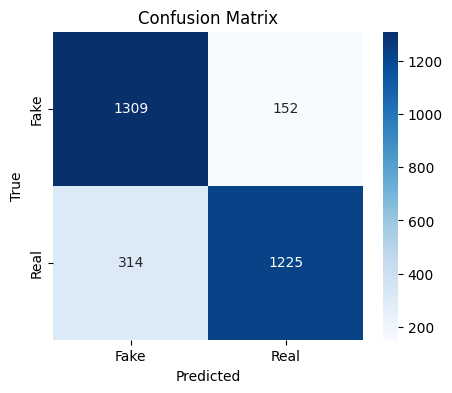

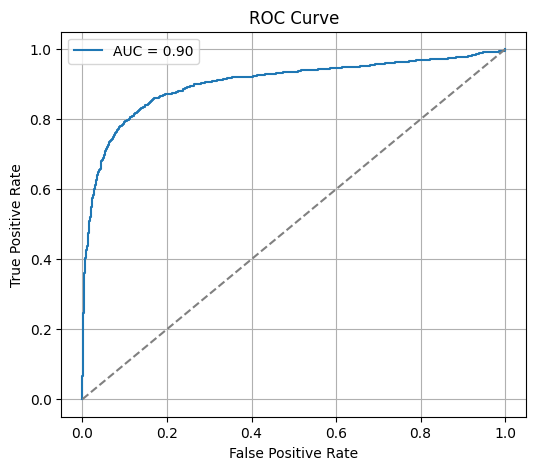

In [126]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate FairWalk model
auc_score = roc_auc_score(y_test, y_proba)
pred_labels = (y_proba > 0.5).astype(int)

# Classification metrics
accuracy = accuracy_score(y_test, pred_labels)
precision = precision_score(y_test, pred_labels)
recall = recall_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

# Print scores
print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Accuracy:      {accuracy:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, pred_labels, target_names=["Fake", "Real"]))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

